In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

In [2]:
normal_train = np.loadtxt("./data/trainA_normal_sepsis.txt")
abnormal_train = np.loadtxt("./data/trainA_abnormal_sepsis.txt")
normal_test = np.loadtxt("./data/testB_normal_sepsis.txt")
abnormal_test = np.loadtxt("./data/testB_abnormal_sepsis.txt")
data_train = np.vstack([normal_train, abnormal_train]).astype(np.float32)
data_test = np.vstack([normal_test, abnormal_test]).astype(np.float32)
vars = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2','BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2',
 'AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium',
 'Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets','Age','Gender', 'Sepsis']
data_train = pd.DataFrame(data_train)
data_train.columns =vars
data_test=pd.DataFrame(data_test)
data_test.columns =vars

In [3]:
data_train['Gender'] = pd.Categorical(data_train.Gender)
data_train['Sepsis'] = pd.Categorical(data_train.Sepsis)
data_train = data_train.astype({'Age':'int'})
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790215 entries, 0 to 790214
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   HR                729026 non-null  float32 
 1   O2Sat             695136 non-null  float32 
 2   Temp              266901 non-null  float32 
 3   SBP               670014 non-null  float32 
 4   MAP               709357 non-null  float32 
 5   DBP               409918 non-null  float32 
 6   Resp              712957 non-null  float32 
 7   EtCO2             0 non-null       float32 
 8   BaseExcess        82381 non-null   float32 
 9   HCO3              63617 non-null   float32 
 10  FiO2              112155 non-null  float32 
 11  pH                90615 non-null   float32 
 12  PaCO2             69288 non-null   float32 
 13  SaO2              39160 non-null   float32 
 14  AST               11820 non-null   float32 
 15  BUN               64476 non-null   float32 
 16  Al

In [4]:
data_test['Gender'] = pd.Categorical(data_test.Gender)
data_test['Sepsis'] = pd.Categorical(data_test.Sepsis)
data_test = data_train.astype({'Age':'int'})
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790215 entries, 0 to 790214
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   HR                729026 non-null  float32 
 1   O2Sat             695136 non-null  float32 
 2   Temp              266901 non-null  float32 
 3   SBP               670014 non-null  float32 
 4   MAP               709357 non-null  float32 
 5   DBP               409918 non-null  float32 
 6   Resp              712957 non-null  float32 
 7   EtCO2             0 non-null       float32 
 8   BaseExcess        82381 non-null   float32 
 9   HCO3              63617 non-null   float32 
 10  FiO2              112155 non-null  float32 
 11  pH                90615 non-null   float32 
 12  PaCO2             69288 non-null   float32 
 13  SaO2              39160 non-null   float32 
 14  AST               11820 non-null   float32 
 15  BUN               64476 non-null   float32 
 16  Al

In [5]:
# drop EtCO2 
data_train = data_train.drop(columns = ['EtCO2'])
data_test = data_test.drop(columns = ['EtCO2'])

In [6]:
# simply impute missing value by mean and mode
from sklearn.impute import SimpleImputer
miss_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
miss_mean_imputer = miss_mean_imputer.fit(data_train)
data_train_impute = miss_mean_imputer.transform(data_train)
data_train_impute = pd.DataFrame(data_train_impute, columns = data_train.columns)
data_train = data_train_impute 

data_train['Gender'] = pd.Categorical(data_train.Gender)
data_train['Sepsis'] = pd.Categorical(data_train.Sepsis)
data_train = data_train.astype({'Age':'int'})
data_train

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Sepsis
0,84.985264,97.265688,37.026737,120.962359,78.767345,59.985809,18.77346,-0.647537,24.094476,0.526248,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,83,0.0,0.0
1,97.000000,95.000000,37.026737,98.000000,75.330002,59.985809,19.00000,-0.647537,24.094476,0.526248,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,83,0.0,0.0
2,89.000000,99.000000,37.026737,122.000000,86.000000,59.985809,22.00000,-0.647537,24.094476,0.526248,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,83,0.0,0.0
3,90.000000,95.000000,37.026737,120.962359,78.767345,59.985809,30.00000,24.000000,24.094476,0.526248,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,83,0.0,0.0
4,103.000000,88.500000,37.026737,122.000000,91.330002,59.985809,24.50000,-0.647537,24.094476,0.280000,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,83,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,88.000000,98.000000,37.026737,135.000000,81.000000,64.000000,16.00000,-0.647537,24.094476,0.500000,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,62,1.0,1.0
790211,96.000000,98.000000,38.720001,174.000000,97.000000,72.000000,16.00000,2.000000,24.094476,0.526248,...,9.288187,27.799999,10.582028,40.781937,11.936604,292.251642,199.617841,62,1.0,1.0
790212,140.000000,97.000000,37.026737,133.000000,81.500000,62.500000,16.00000,-0.647537,24.094476,0.526248,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,62,1.0,1.0
790213,120.000000,96.000000,37.026737,154.000000,118.000000,105.000000,16.00000,-0.647537,24.094476,0.526248,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,62,1.0,1.0


In [7]:
from sklearn.impute import SimpleImputer
miss_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
miss_mean_imputer = miss_mean_imputer.fit(data_test)
data_test_impute = miss_mean_imputer.transform(data_test)
data_test_impute = pd.DataFrame(data_test_impute, columns = data_test.columns)
data_test = data_test_impute 

data_test['Gender'] = pd.Categorical(data_test.Gender)
data_test['Sepsis'] = pd.Categorical(data_test.Sepsis)
data_test = data_train.astype({'Age':'int'})
data_test

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Sepsis
0,84.985264,97.265688,37.026737,120.962359,78.767345,59.985809,18.77346,-0.647537,24.094476,0.526248,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,83,0.0,0.0
1,97.000000,95.000000,37.026737,98.000000,75.330002,59.985809,19.00000,-0.647537,24.094476,0.526248,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,83,0.0,0.0
2,89.000000,99.000000,37.026737,122.000000,86.000000,59.985809,22.00000,-0.647537,24.094476,0.526248,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,83,0.0,0.0
3,90.000000,95.000000,37.026737,120.962359,78.767345,59.985809,30.00000,24.000000,24.094476,0.526248,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,83,0.0,0.0
4,103.000000,88.500000,37.026737,122.000000,91.330002,59.985809,24.50000,-0.647537,24.094476,0.280000,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,83,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,88.000000,98.000000,37.026737,135.000000,81.000000,64.000000,16.00000,-0.647537,24.094476,0.500000,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,62,1.0,1.0
790211,96.000000,98.000000,38.720001,174.000000,97.000000,72.000000,16.00000,2.000000,24.094476,0.526248,...,9.288187,27.799999,10.582028,40.781937,11.936604,292.251642,199.617841,62,1.0,1.0
790212,140.000000,97.000000,37.026737,133.000000,81.500000,62.500000,16.00000,-0.647537,24.094476,0.526248,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,62,1.0,1.0
790213,120.000000,96.000000,37.026737,154.000000,118.000000,105.000000,16.00000,-0.647537,24.094476,0.526248,...,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,62,1.0,1.0


some notes: \
$1.$ `Gender` (Categorical, dummy variables, can't standardize) considered as integer to predict, `Age` considered as general integer and can be standardized \
$2.$ convert both of X and Y (because of log loss) to float32 (include dummy variable considered as numerical) to predict \
$3.$ Dummy variables are independent variables which take the value of either 0 or 1. Just as a "dummy" is a stand-in for a real person, in quantitative analysis, a dummy variable is a numeric stand-in for a qualitative fact or a logical proposition.

In [8]:
# split train for numerical and categorical to do the standardization
data_train_num, data_train_cat = data_train.iloc[:, 0:34], data_train.iloc[:, 34:36]
data_test_num,  data_test_cat = data_test.iloc[:, 0:34], data_test.iloc[:, 34:36]

from sklearn.preprocessing import StandardScaler
## standardize with same scaler between train and test 
scaler = StandardScaler()
scaler.fit(data_train_num)
data_train_num = scaler.transform(data_train_num)
data_test_num = scaler.transform(data_test_num)

# together within/out standardizaiton
data_train = np.column_stack((data_train_num, data_train_cat))
data_test = np.column_stack((data_test_num, data_test_cat))

# convert to dataframe
vars = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2',
 'AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium',
 'Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets','Age','Gender', 'Sepsis']
data_train = pd.DataFrame(data_train)
data_train.columns =vars
data_test=pd.DataFrame(data_test)
data_test.columns =vars

In [9]:
# split X and y
x_train, y_train = data_train.iloc[:, 0:35], data_train.iloc[:, 35]
x_test, y_test = data_test.iloc[:, 0:35], data_test.iloc[:, 35]

# convert both of X and Y (because of log loss) to float32 (include dummy variable considered as numerical) to predict 
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

In [10]:
# class Normalize(tf.Module):
    # def __init__(self, x):
        # # Initialize the mean and standard deviation for normalization
        # self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
        # self.std = tf.Variable(tf.math.reduce_std(x, axis=0))
# 
    # def norm(self, x):
        # # Normalize the input
        # return (x - self.mean)/self.std
# 
    # def unnorm(self, x):
        # # Unnormalize the input
        # return (x * self.std) + self.mean
# 
# # make sure used the same scaler
# norm_x = Normalize(x_train)
# x_train, x_test = norm_x.norm(x_train), norm_x.norm(x_test)

### Tensorflow2.x
https://www.tensorflow.org/guide/core/logistic_regression_core
(x.shape[-1],1), dimension of columns -> [Dimension(35), 1]: https://stackoverflow.com/questions/66129709/what-does-a-1-mean-in-the-shape-of-a-tensor-input
tf.random.uniform:https://www.tensorflow.org/api_docs/python/tf/random/uniform
tf.Variable: https://www.tensorflow.org/api_docs/python/tf/Variable
tf.matmul: dot product: https://www.geeksforgeeks.org/tensorflow-js-tf-matmul-function/
tf.add: addition aggregation 
tf.squeeze, Removes dimensions of size 1 from the shape of a tensor, -> shape=(5,): https://www.tensorflow.org/api_docs/python/tf/squeeze

#### logistic regression def

In [11]:
print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.6.0


In [12]:
# the log loss function
def log_loss(y_pred, y):
    # Compute the log loss function
    ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(ce)

In [13]:
class LogisticRegression(tf.Module): # https://www.tensorflow.org/api_docs/python/tf/Module

    def __init__(self):
        self.built = False
        
    def __call__(self, x, train=True):
        # Initialize the model parameters on the first call
        if not self.built:
            # Randomly generate the weights and the bias term
            rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
            rand_b = tf.random.uniform(shape=[], seed=22)
            self.w = tf.Variable(rand_w)
            self.b = tf.Variable(rand_b)
            self.built = True
        # Compute the model output
        z = tf.add(tf.matmul(x, self.w), self.b)
        z = tf.squeeze(z, axis=1)
        if train:
            return z
        # make sure the test outputs values in the range of (0, 1) 
        return tf.sigmoid(z)

In [14]:
# To validate, make sure the untrained model outputs values in the range of (0, 1) for a small subset of the training data.
log_reg = LogisticRegression()
# y_pred = log_reg(x_train[:5], train=False)
# y_pred.numpy()

In [15]:
def predict_class(y_pred, thresh=0.5):
    # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
    return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
    # Return the proportion of matches between `y_pred` and `y`
    y_pred = tf.math.sigmoid(y_pred) # since default train=True
    y_pred_class = predict_class(y_pred)
    check_equal = tf.cast(y_pred_class == y,tf.float32)
    acc_val = tf.reduce_mean(check_equal)
    return acc_val

#### Train the model

In [16]:
batch_size = 12800
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
# Set training parameters
epochs = 1500
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []
train_aucs, test_aucs = [], []
train_aps, test_aps = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
    batch_losses_train, batch_accs_train, batch_aucs_train, batch_aps_train = [], [], [], []
    batch_losses_test, batch_accs_test, batch_aucs_test, batch_aps_test = [], [], [], []

    # Iterate over the training data
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred_batch = log_reg(x_batch)
            batch_loss = log_loss(y_pred_batch, y_batch)
            batch_acc = accuracy(y_pred_batch, y_batch)
            batch_ap = average_precision_score(y_batch, y_pred_batch)
            try:
                batch_auc = roc_auc_score(y_batch, y_pred_batch)
            except ValueError:
                pass
        # Update the parameters with respect to the gradient calculations
        grads = tape.gradient(batch_loss, log_reg.variables)
        for g,v in zip(grads, log_reg.variables):
            v.assign_sub(learning_rate * g)
        # Keep track of batch-level training performance
        batch_losses_train.append(batch_loss)
        batch_accs_train.append(batch_acc)
        batch_aucs_train.append(batch_auc)
        batch_aps_train.append(batch_ap)
  
    # Iterate over the testing data
    for x_batch, y_batch in test_dataset:
        y_pred_batch = log_reg(x_batch)
        batch_loss = log_loss(y_pred_batch, y_batch)
        batch_acc = accuracy(y_pred_batch, y_batch)
        batch_ap = average_precision_score(y_batch, y_pred_batch)
        try:
            batch_auc = roc_auc_score(y_batch, y_pred_batch)
        except ValueError:
            pass
        # Keep track of batch-level testing performance
        batch_losses_test.append(batch_loss)
        batch_accs_test.append(batch_acc)
        batch_aucs_test.append(batch_auc)
        batch_aps_test.append(batch_ap)

    # Keep track of epoch-level model performance
    # take average of batches
    train_loss, train_acc, train_auc, train_ap = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train), tf.reduce_mean(batch_aucs_train), tf.reduce_mean(batch_aps_train)
    test_loss, test_acc, test_auc, test_ap = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test), tf.reduce_mean(batch_aucs_test), tf.reduce_mean(batch_aps_test)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_aucs.append(test_auc)
    test_aps.append(test_ap)

    if epoch % 30 == 0:
        print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}, Training acc: {train_acc:.3f}, Training ap: {train_ap: .3f}, Training auc: {train_auc:.3f}")
        print(f"Epoch: {epoch}, Testing log loss: {test_loss:.3f}, Testing acc: {test_acc:.3f}, Testing ap: {test_ap: .3f}, Testing auc: {test_auc:.3f}")

Epoch: 0, Training log loss: 1.562, Training acc: 0.394, Training ap:  0.028, Training auc: 0.528
Epoch: 0, Testing log loss: 1.408, Testing acc: 0.444, Testing ap:  0.028, Testing auc: 0.527
Epoch: 30, Training log loss: 0.154, Training acc: 0.970, Training ap:  0.026, Training auc: 0.517
Epoch: 30, Testing log loss: 0.153, Testing acc: 0.970, Testing ap:  0.026, Testing auc: 0.517
Epoch: 60, Training log loss: 0.117, Training acc: 0.977, Training ap:  0.027, Training auc: 0.529
Epoch: 60, Testing log loss: 0.117, Testing acc: 0.977, Testing ap:  0.027, Testing auc: 0.529
Epoch: 90, Training log loss: 0.110, Training acc: 0.978, Training ap:  0.028, Training auc: 0.538
Epoch: 90, Testing log loss: 0.110, Testing acc: 0.978, Testing ap:  0.028, Testing auc: 0.538
Epoch: 120, Training log loss: 0.108, Training acc: 0.978, Training ap:  0.029, Training auc: 0.545
Epoch: 120, Testing log loss: 0.108, Testing acc: 0.978, Testing ap:  0.029, Testing auc: 0.545
Epoch: 150, Training log loss:

### Performance evaluation

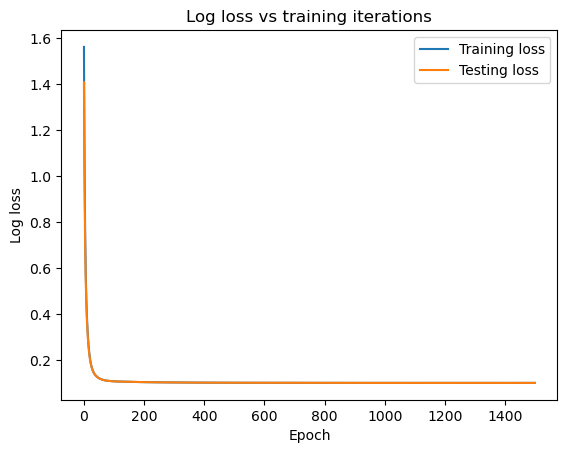

In [19]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

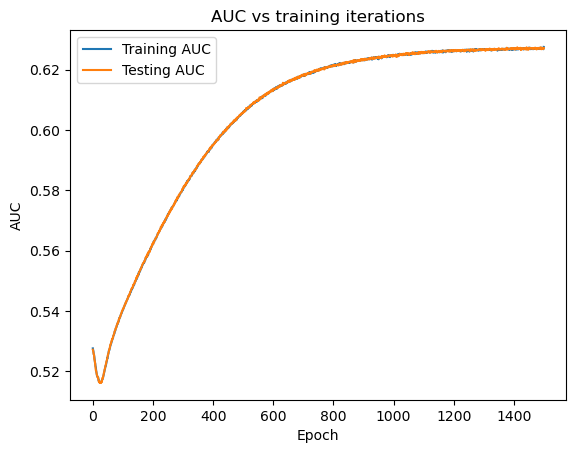

In [20]:
plt.plot(range(epochs), train_aucs, label = "Training AUC")
plt.plot(range(epochs), test_aucs, label = "Testing AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.title("AUC vs training iterations");

### Weighted Cross Entropy Loss: 

In [11]:
print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.6.0


In [12]:
# the log loss function
def log_loss(y_pred, y):
    # Compute the log loss function
    ce = tf.nn.weighted_cross_entropy_with_logits(labels=y, logits=y_pred, pos_weight=50)
    return tf.reduce_mean(ce)

In [13]:
class LogisticRegression(tf.Module): # https://www.tensorflow.org/api_docs/python/tf/Module

    def __init__(self):
        self.built = False
        
    def __call__(self, x, train=True):
        # Initialize the model parameters on the first call
        if not self.built:
            # Randomly generate the weights and the bias term
            rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
            rand_b = tf.random.uniform(shape=[], seed=22)
            self.w = tf.Variable(rand_w)
            self.b = tf.Variable(rand_b)
            self.built = True
        # Compute the model output
        z = tf.add(tf.matmul(x, self.w), self.b)
        z = tf.squeeze(z, axis=1)
        if train:
            return z
        # make sure the test outputs values in the range of (0, 1) 
        return tf.sigmoid(z)

In [14]:
# To validate, make sure the untrained model outputs values in the range of (0, 1) for a small subset of the training data.
log_reg = LogisticRegression()
# y_pred = log_reg(x_train[:5], train=False)
# y_pred.numpy()

In [15]:
def predict_class(y_pred, thresh=0.5):
    # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
    return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
    # Return the proportion of matches between `y_pred` and `y`
    y_pred = tf.math.sigmoid(y_pred) # since default train=True
    y_pred_class = predict_class(y_pred)
    check_equal = tf.cast(y_pred_class == y,tf.float32)
    acc_val = tf.reduce_mean(check_equal)
    return acc_val

In [16]:
batch_size = 12800
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [17]:
import warnings
warnings.filterwarnings("ignore")

# Set training parameters
epochs = 300
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []
train_aucs, test_aucs = [], []
train_aps, test_aps = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
    batch_losses_train, batch_accs_train, batch_aucs_train, batch_aps_train = [], [], [], []
    batch_losses_test, batch_accs_test, batch_aucs_test, batch_aps_test = [], [], [], []

    # Iterate over the training data
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred_batch = log_reg(x_batch)
            batch_loss = log_loss(y_pred_batch, y_batch)
            batch_acc = accuracy(y_pred_batch, y_batch)
            batch_ap = average_precision_score(y_batch, y_pred_batch)
            try:
                batch_auc = roc_auc_score(y_batch, y_pred_batch)
            except ValueError:
                pass
        # Update the parameters with respect to the gradient calculations
        grads = tape.gradient(batch_loss, log_reg.variables)
        for g,v in zip(grads, log_reg.variables):
            v.assign_sub(learning_rate * g)
        # Keep track of batch-level training performance
        batch_losses_train.append(batch_loss)
        batch_accs_train.append(batch_acc)
        batch_aucs_train.append(batch_auc)
        batch_aps_train.append(batch_ap)
  
    # Iterate over the testing data
    for x_batch, y_batch in test_dataset:
        y_pred_batch = log_reg(x_batch)
        batch_loss = log_loss(y_pred_batch, y_batch)
        batch_acc = accuracy(y_pred_batch, y_batch)
        batch_ap = average_precision_score(y_batch, y_pred_batch)
        try:
            batch_auc = roc_auc_score(y_batch, y_pred_batch)
        except ValueError:
            pass
        # Keep track of batch-level testing performance
        batch_losses_test.append(batch_loss)
        batch_accs_test.append(batch_acc)
        batch_aucs_test.append(batch_auc)
        batch_aps_test.append(batch_ap)

    # Keep track of epoch-level model performance
    # take average of batches
    train_loss, train_acc, train_auc, train_ap = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train), tf.reduce_mean(batch_aucs_train), tf.reduce_mean(batch_aps_train)
    test_loss, test_acc, test_auc, test_ap = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test), tf.reduce_mean(batch_aucs_test), tf.reduce_mean(batch_aps_test)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_aucs.append(test_auc)
    test_aps.append(test_ap)

    if epoch % 30 == 0:
        print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}, Training acc: {train_acc:.3f}, Training ap: {train_ap: .3f}, Training auc: {train_auc:.3f}")
        print(f"Epoch: {epoch}, Testing log loss: {test_loss:.3f}, Testing acc: {test_acc:.3f}, Testing ap: {test_ap: .3f}, Testing auc: {test_auc:.3f}")

Epoch: 0, Training log loss: 2.651, Training acc: 0.345, Training ap:  0.028, Training auc: 0.532
Epoch: 0, Testing log loss: 2.500, Testing acc: 0.341, Testing ap:  0.028, Testing auc: 0.536
Epoch: 30, Training log loss: 1.383, Training acc: 0.507, Training ap:  0.038, Training auc: 0.623
Epoch: 30, Testing log loss: 1.382, Testing acc: 0.508, Testing ap:  0.038, Testing auc: 0.624
Epoch: 60, Training log loss: 1.375, Training acc: 0.524, Training ap:  0.039, Training auc: 0.628
Epoch: 60, Testing log loss: 1.375, Testing acc: 0.523, Testing ap:  0.040, Testing auc: 0.628
Epoch: 90, Training log loss: 1.375, Training acc: 0.524, Training ap:  0.039, Training auc: 0.628
Epoch: 90, Testing log loss: 1.375, Testing acc: 0.525, Testing ap:  0.040, Testing auc: 0.628
Epoch: 120, Training log loss: 1.375, Training acc: 0.525, Training ap:  0.040, Training auc: 0.628
Epoch: 120, Testing log loss: 1.375, Testing acc: 0.526, Testing ap:  0.040, Testing auc: 0.628
Epoch: 150, Training log loss:

Text(0.5, 1.0, 'Weighted Log loss vs training iterations')

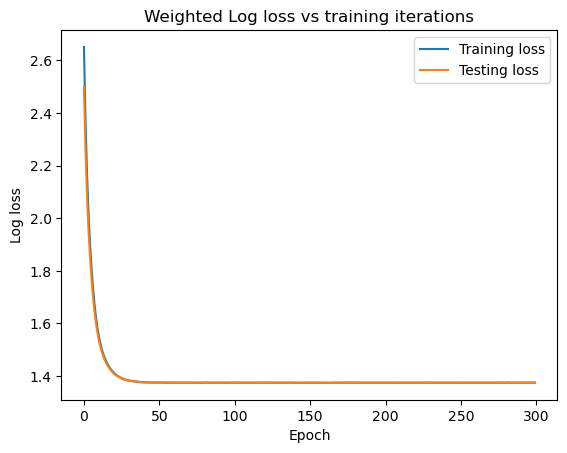

In [19]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Weighted Log loss vs training iterations")

Text(0.5, 1.0, 'AUC vs training iterations by weights')

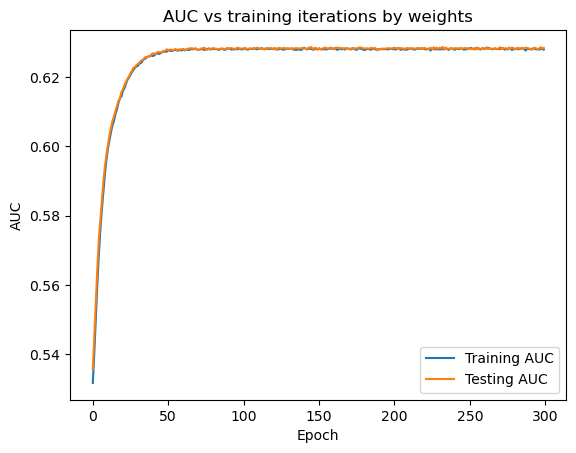

In [20]:
plt.plot(range(epochs), train_aucs, label = "Training AUC")
plt.plot(range(epochs), test_aucs, label = "Testing AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.title("AUC vs training iterations by weights")